In [1]:
import numpy as np
import pandas as pd
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys
import pickle
from time import time

import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

#### 读取数据

In [2]:
sys.path.append('..')
import dataloader
importlib.reload(dataloader)
import model
#importlib.reload(model)
from dataloader import DataLoader
importlib.reload(DataLoader)
from model.DeepModel import * 
#importlib.reload(model.DeepModel)
DL = DataLoader.DataLoader(device='cpu')
# DL.process_raw_data()

reading global_chord_num_dic
reading global_num_chord_dic
reading global_num_chord_one_hot_dic
reading double_compressed_data


#### 统计大小调所有和弦数目，出现的三，七和弦数目以及全部使用三，七和弦的样本数

In [3]:
total = 0  # 出现的和弦总数
triad_num = 0  # 三和弦总数
triad_num_dic = {'minor':{i:0 for i in DL.global_chord_num_dic['minor'].keys()},
                 'major':{i:0 for i in DL.global_chord_num_dic['major'].keys()}}
triad_sample_num = 0 # 全部使用三和弦的样本数
triad_samples = {'major': [], 'minor': []}
for sample in DL.double_compressed_data:
    if sample['key'] in ['A','B','C','D','E','F','G']:
        m = 'major'
    else:
        m = 'minor'
    sample_copy = sample.copy()
    melody = sample['melody']
    chord = sample['chord']
    t = True
    for i in range(len(melody)):
        total += 1
        try:
            DL.global_chord_num_dic[m][chord[i]]
            triad_num_dic[m][chord[i]] += 1
            triad_num += 1
        except:
            if len(chord[i]) < 3:
                for c in DL.global_chord_num_dic[m].keys():
                    if melody[i] not in c:
                        continue
                    for k in chord[i]:
                        if k not in c:
                            break
                    else:
                        sample_copy['chord'][i] = c
                        triad_num_dic[m][c] += 1
                        triad_num += 1
                        break
                else:
                    t = False
            else:
                t = False
                pass
    if t:
        triad_samples[m].append(sample_copy)
        triad_sample_num += 1

print(total)
print(triad_num)
print(triad_sample_num)

306469
142234
3329


## 模型训练

#### 大调不加权

In [4]:
DL.get_train_data(min_length=1, write_cache=False, valid_compressed_data=triad_samples['major'])

10000 valid train_data
20000 valid train_data
30000 valid train_data
total 32003 valid train_data


In [9]:
device = 'cuda'
model = ChordLstmNet(chord_num=39, melody_keys=12, hidden_size=128, num_layers=2, bidirectional=False,
                 alpha=0.2, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

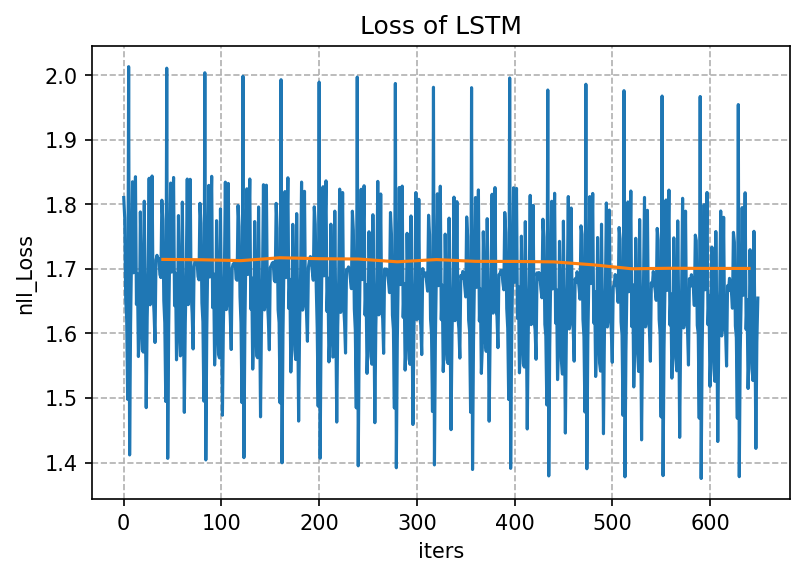

In [22]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*40 for i in range(1,17)], test_loss, label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.ylabel('nll_Loss')
plt.title('Loss of LSTM')
plt.show()

## 基本统计数据

#### 三和弦频数分布

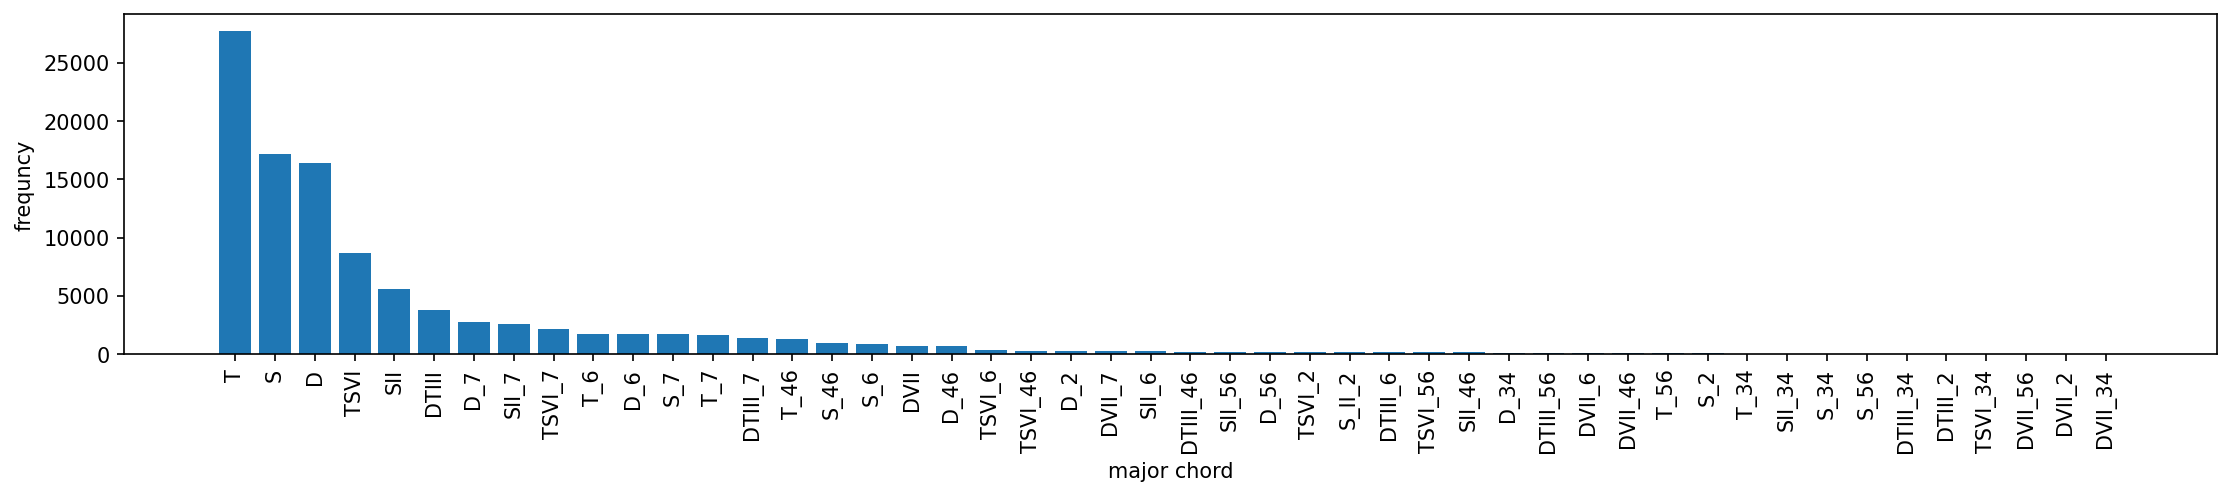

In [13]:
m = 'major'
num_dic = [(key, value) for key, value in triad_num_dic[m].items()]
num_dic = sorted(num_dic, key=lambda x:-x[1])
num = [i[1] for i in num_dic]
chord = [DL.chord_name_dic[i[0]] for i in num_dic]

plt.figure(figsize=(18,3),dpi=150)
plt.bar([i for i in range(len(num_dic))], num)
plt.xticks([i for i in range(len(num_dic))], chord, rotation=90)
#plt.grid(linestyle='--')
plt.ylabel('frequncy')
plt.xlabel('major chord')
plt.show()

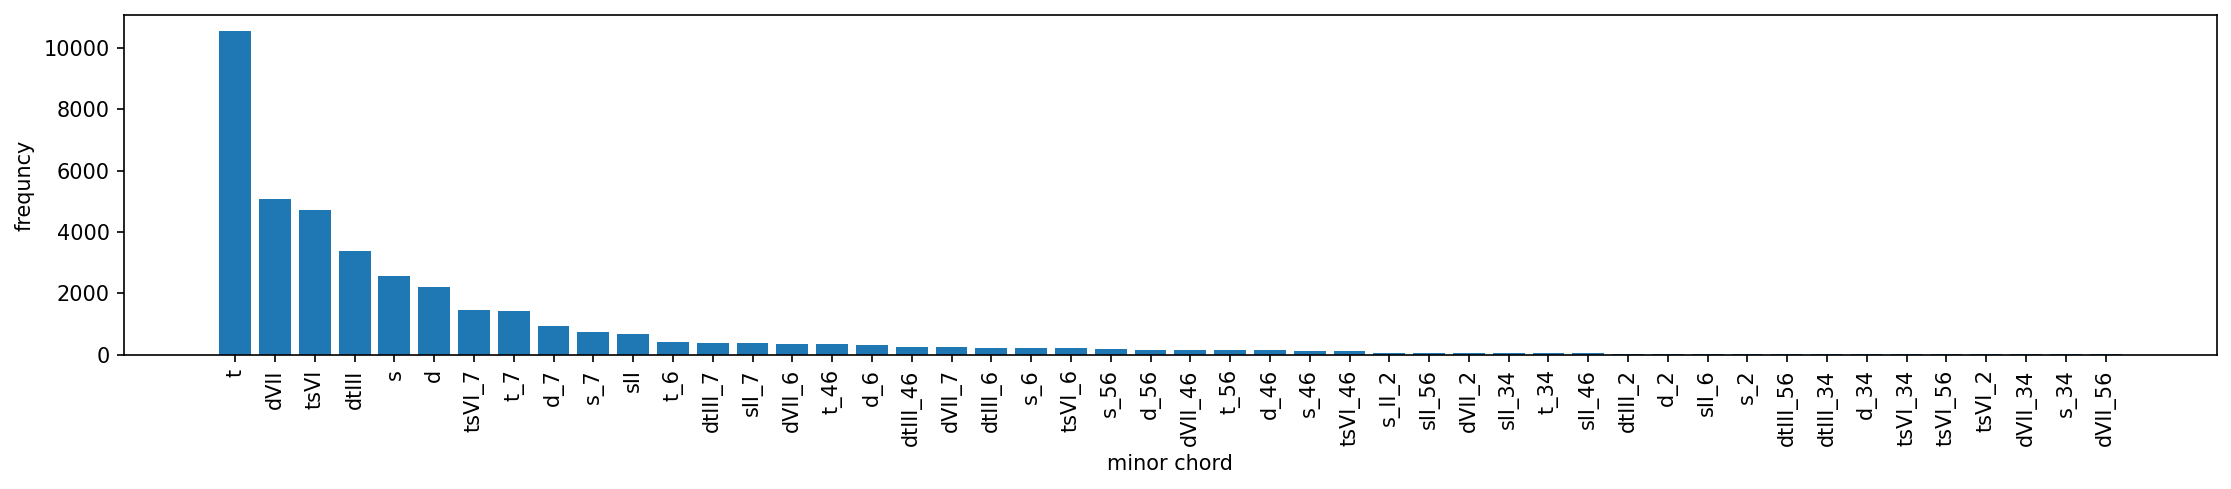

In [14]:
m = 'minor'
num_dic = [(key, value) for key, value in triad_num_dic[m].items()]
num_dic = sorted(num_dic, key=lambda x:-x[1])
num = [i[1] for i in num_dic]
chord = [DL.chord_name_dic[i[0]] for i in num_dic]

plt.figure(figsize=(18,3),dpi=150)
plt.bar([i for i in range(len(num_dic))], num)
plt.xticks([i for i in range(len(num_dic))], chord, rotation=90)
#plt.grid(linestyle='--')
plt.ylabel('frequncy')
plt.xlabel('minor chord')
plt.show()

## 测试

#### 均匀抽样的回溯算法

In [116]:
import generator
importlib.reload(generator)
from generator import Generator
importlib.reload(Generator)
import rule
importlib.reload(rule)
from rule import Rule
importlib.reload(Rule)
rules = Rule.Rule()

In [117]:
CG = Generator.ChordGenerator(DL.num_chord_dic)

In [118]:
melody = np.array([0,4,9])
CG.rule = rules
c = CG.generate(melody)
print(c)

[0, 1, 2, 9, 10, 11, 15, 16, 17, 21, 22, 23, 27, 28, 29, 33, 34, 35]
28
(8, 0, 5) 0 (0, 4, 7) 4 p eight
(8, 0, 5) 0 (7, 0, 4) 4 hidden eight
(8, 0, 5) 0 (7, 11, 4) 4 hidden eight
(8, 0, 5) 0 (11, 4, 7) 4 p eight
(8, 0, 5) 0 (9, 0, 4) 4 hidden eight
(8, 0, 5) 0 (0, 4, 9) 4 p eight
[]
(3, 7, 0) 0 (4, 7, 0) 4 hidden eight
(3, 7, 0) 0 (7, 0, 4) 4 p eight
(3, 7, 0) 0 (4, 7, 11) 4 hidden eight
(3, 7, 0) 0 (7, 11, 4) 4 p eight
(3, 7, 0) 0 (9, 0, 4) 4 p eight
(3, 7, 0) 0 (4, 9, 0) 4 hidden eight
[]
(0, 5, 9) 0 (0, 4, 7) 4 hidden eight
(0, 5, 9) 0 (4, 7, 0) 4 p eight
(0, 5, 9) 0 (4, 7, 11) 4 p eight
(0, 5, 9) 0 (11, 4, 7) 4 hidden eight
(0, 5, 9) 0 (0, 4, 9) 4 hidden eight
(0, 5, 9) 0 (4, 9, 0) 4 p eight
[]
(0, 3, 8) 0 (0, 4, 7) 4 hidden eight
(0, 3, 8) 0 (4, 7, 0) 4 p eight
(0, 3, 8) 0 (4, 7, 11) 4 p eight
(0, 3, 8) 0 (11, 4, 7) 4 hidden eight
(0, 3, 8) 0 (0, 4, 9) 4 hidden eight
(0, 3, 8) 0 (4, 9, 0) 4 p eight
[]
(7, 0, 4) 0 (0, 4, 7) 4 p eight
(7, 0, 4) 0 (11, 4, 7) 4 p eight
(7, 0, 4) 0 (0,

In [119]:
for i in c:
    print(DL.num_chord_dic[i])

(7, 0, 4)
(4, 9, 0)
(4, 9, 0)
